In [68]:
pip install -r "..\requirements.txt"

Note: you may need to restart the kernel to use updated packages.


In [69]:
import re
import numpy as np
import pandas as pd
import matplotlib as plt 
from scipy import stats
from statsmodels.stats.multitest import multipletests
import pingouin as pg

# Vorbereitung der Daten

In [70]:
df = pd.read_csv(r"Ergebnisse Umfrage vollständig.csv", sep=";")
df.head()

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,CF[EQ01],CF[EQ02],CF[EQ03],...,Vorwissen_fach0v2,interviewtime,CFTime,NNTime,AnchorTime,LIMETime,SHAPTime,DTTime,RangTime,KV1Time
0,10,08.09.2025 10:59,8,de,1430164265,08.09.2025 10:47,08.09.2025 10:59,3,4,4,...,0,"714,93","98,76","80,98","150,93","140,26","72,15","110,16","48,42","13,27"
1,13,09.09.2025 19:44,8,de,1946535822,09.09.2025 19:16,09.09.2025 19:44,6,5,2,...,0,"1660,19","297,56","236,21","154,63",412,"342,94","98,32","100,11","18,42"
2,16,09.09.2025 20:12,8,de,1383825229,09.09.2025 19:49,09.09.2025 20:12,6,1,1,...,1,"1384,95","157,95","374,83","253,29","172,51","184,3","87,06","111,96","43,05"
3,28,10.09.2025 11:35,8,de,1436651720,10.09.2025 11:08,10.09.2025 11:35,1,6,7,...,0,"1605,81","122,8","135,54","105,61","138,45","222,24","813,46","47,06","20,65"
4,40,10.09.2025 11:42,8,de,766766586,10.09.2025 11:33,10.09.2025 11:42,1,1,1,...,0,"548,08","29,53","49,64","63,37","59,85","37,78","213,07","75,34","19,5"


In [71]:
# Vorwissen auf Laien beschränken
df = df[~(df["Vorwissen_fach"].eq(2)) & ~(df["Vorwissen_tech"].eq(2))]

In [72]:
# ErsetzungsDict = {
#     "Schulabschuss": 1,
#     "Ausbildung u. ä.": 2,
#     "Bachelor/ Techniker/ Meister u. ä.": 3,
#     "Master/ Diplom u. ä.": 4,
#     "Doktor": 5}
# df["Abschluss"] = df["Abschluss"].map(ErsetzungsDict)

In [73]:
List_XAI_Abbr = ["CF", "NN", "Anchor", "LIME", "SHAP", "DT"]
List_XAI_Darstellung = ["Darstellung C", "Darstellung N", "Darstellung A", "Darstellung L", "Darstellung S", "Darstellung D"]
plt_color=(0, 0.412, 0.706, 1.0) #RGB: 0 | 105 | 180

In [74]:
def add_sum(column_prefix):
    sum_column_name = f"Sum_{column_prefix}"
    question_columns = [f"{column_prefix}[EQ{str(i).zfill(2)}]" for i in range(1, 9)]
    df[sum_column_name] = df[question_columns].sum(axis=1)

In [75]:
for abbr in List_XAI_Abbr:
    add_sum(abbr)

In [76]:
# Transformation des Rankings
def transform_ranking(df):
    for i, row in df.iterrows():
        for col in df[["Rang[1]", "Rang[2]", "Rang[3]", "Rang[4]", "Rang[5]", "Rang[6]"]]:
            rank = int(col.split("[")[1].split("]")[0])  # Rangzahl extrahieren
            method = row[col]                           # z. B. "L"
            df.loc[i, method] = rank

    return df

In [77]:
for col in List_XAI_Darstellung:
    if col not in df.columns:
        df[col] = np.nan

df = transform_ranking(df)

# deskriptive Analyse

In [78]:
List_XAI_Sum = ["Sum_CF", "Sum_NN", "Sum_Anchor", "Sum_LIME", "Sum_SHAP", "Sum_DT"]
abbr_to_fullname = {
    "CF": "Counterfactuals",
    "NN": "Nearest Neighbors",
    "Anchor": "Anchor",
    "LIME": "LIME",
    "SHAP": "SHAP",
    "DT": "Entscheidungsbaum"
}

In [79]:
df_desk_analyse = pd.DataFrame(columns=["Methode", "N", "Mittelwert",  "StdAbw", "Varianz", "Min", "1. Quartil", "Median", "3. Quartil", "Max", "IQA", "Schiefe", "Kurtosis"])

In [80]:
def deskriptive_analyse(xai_methode):
    for item in List_XAI_Sum:
        s = pd.Series(df[item])
        df_desk_analyse.loc[len(df_desk_analyse)] = [
            abbr_to_fullname[item.split("_")[1]],
            s.count(),
            round(s.mean(), 2),
            round(s.std(), 2),
            round(s.var(), 2),
            s.min(),
            s.quantile(0.25),
            s.median(),
            s.quantile(0.75),
            s.max(),
            round(s.quantile(0.75) - s.quantile(0.25), 2),  # IQA
            round(stats.skew(s, bias=False), 2),
            round(stats.kurtosis(s, bias=False, fisher=True), 2)
        ]

deskriptive_analyse(List_XAI_Sum)
df_desk_analyse

,Methode,N,Mittelwert,StdAbw,Varianz,Min,1. Quartil,Median,3. Quartil,Max,IQA,Schiefe,Kurtosis
0,Counterfactuals,51,31.88,12.73,162.07,8,21.0,31.0,42.0,55,21.0,-0.05,-0.94
1,Nearest Neighbors,51,31.53,11.82,139.73,10,23.5,30.0,39.0,56,15.5,0.32,-0.47
2,Anchor,51,45.33,9.66,93.31,14,39.5,48.0,53.0,56,13.5,-1.02,0.77
3,LIME,51,40.33,11.51,132.43,9,33.0,44.0,49.5,56,16.5,-0.60,-0.45
4,SHAP,51,28.22,12.94,167.49,8,18.5,27.0,38.0,55,19.5,0.24,-0.77
5,Entscheidungsbaum,51,43.94,10.76,115.86,16,39.5,45.0,53.0,56,13.5,-0.93,0.20


In [81]:
# deskriptive Analyse der Items pro XAI-Methode
def deskriptive_analyse_items(xai_methode):
    for abbr in List_XAI_Abbr:
        question_columns = [f"{abbr}[EQ{str(i).zfill(2)}]" for i in range(1, 9)]
        for col in question_columns:
            s = pd.Series(df[col])
            df_desk_analyse.loc[len(df_desk_analyse)] = [
                f"{abbr_to_fullname[abbr]} - {col.split('[')[1].split(']')[0]}",
                s.count(),
                round(s.mean(), 2),
                round(s.std(), 2),
                round(s.var(), 2),
                s.min(),
                s.quantile(0.25),
                s.median(),
                s.quantile(0.75),
                s.max(),
                round(s.quantile(0.75) - s.quantile(0.25), 2),  # IQA
                round(stats.skew(s, bias=False), 2),
                round(stats.kurtosis(s, bias=False, fisher=True), 2)
            ]

deskriptive_analyse_items(List_XAI_Abbr)
df_desk_analyse

,Methode,N,Mittelwert,StdAbw,Varianz,Min,1. Quartil,Median,3. Quartil,Max,IQA,Schiefe,Kurtosis
0,Counterfactuals,51,31.88,12.73,162.07,8,21.0,31.0,42.0,55,21.0,-0.05,-0.94
1,Nearest Neighbors,51,31.53,11.82,139.73,10,23.5,30.0,39.0,56,15.5,0.32,-0.47
2,Anchor,51,45.33,9.66,93.31,14,39.5,48.0,53.0,56,13.5,-1.02,0.77
3,LIME,51,40.33,11.51,132.43,9,33.0,44.0,49.5,56,16.5,-0.60,-0.45
4,SHAP,51,28.22,12.94,167.49,8,18.5,27.0,38.0,55,19.5,0.24,-0.77
5,Entscheidungsbaum,51,43.94,10.76,115.86,16,39.5,45.0,53.0,56,13.5,-0.93,0.20
6,Counterfactuals - EQ01,51,3.82,1.87,3.51,1,2.0,4.0,5.0,7,3.0,0.08,-1.18
7,Counterfactuals - EQ02,51,4.29,1.88,3.53,1,3.0,5.0,6.0,7,3.0,-0.26,-1.16
8,Counterfactuals - EQ03,51,4.22,2.02,4.09,1,2.5,4.0,6.0,7,3.5,-0.11,-1.24
9,Counterfactuals - EQ04,51,4.16,1.91,3.65,1,3.0,4.0,6.0,7,3.0,-0.11,-1.20


In [82]:
# Erstellung einer Tabelle mit den Spalten Item, CF, NN, Anchor, LIME, SHAP, DT und als Zellenwert den Median mit dem [1. Quartil - 3. Quartil] in eckigen Klammern dahinter
rows = []
for i in range(1, 9):
    item_name = f"EQ{str(i).zfill(2)}"
    row = {"Item": item_name}
    for abbr in List_XAI_Abbr:
        col_name = f"{abbr}[{item_name}]"
        s = pd.Series(df[col_name])
        median = round(s.median(), 0)
        q1 = round(s.quantile(0.25), 0)
        q3 = round(s.quantile(0.75), 0)
        row[abbr] = f"{median} [{q1} - {q3}]"
    rows.append(row)
df_median_iqa_items = pd.DataFrame(rows, columns=["Item"] + List_XAI_Abbr)

In [83]:
# Drehung der df_desk_analyse
df_desk_analyse = df_desk_analyse.set_index("Methode").T
df_desk_analyse

Methode,Counterfactuals,Nearest Neighbors,Anchor,LIME,SHAP,Entscheidungsbaum,Counterfactuals - EQ01,Counterfactuals - EQ02,Counterfactuals - EQ03,Counterfactuals - EQ04,...,SHAP - EQ07,SHAP - EQ08,Entscheidungsbaum - EQ01,Entscheidungsbaum - EQ02,Entscheidungsbaum - EQ03,Entscheidungsbaum - EQ04,Entscheidungsbaum - EQ05,Entscheidungsbaum - EQ06,Entscheidungsbaum - EQ07,Entscheidungsbaum - EQ08
N,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,...,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
Mittelwert,31.88,31.53,45.33,40.33,28.22,43.94,3.82,4.29,4.22,4.16,...,3.12,2.86,5.37,5.88,5.71,5.78,5.90,4.84,5.12,5.33
StdAbw,12.73,11.82,9.66,11.51,12.94,10.76,1.87,1.88,2.02,1.91,...,1.80,1.91,1.84,1.60,1.58,1.24,1.19,2.24,1.76,1.80
Varianz,162.07,139.73,93.31,132.43,167.49,115.86,3.51,3.53,4.09,3.65,...,3.23,3.64,3.40,2.55,2.49,1.53,1.41,5.01,3.11,3.23
Min,8.00,10.00,14.00,9.00,8.00,16.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,2.00,3.00,1.00,1.00,1.00
1. Quartil,21.00,23.50,39.50,33.00,18.50,39.50,2.00,3.00,2.50,3.00,...,1.00,1.00,4.50,5.00,5.00,5.00,5.00,3.00,4.00,5.00
Median,31.00,30.00,48.00,44.00,27.00,45.00,4.00,5.00,4.00,4.00,...,3.00,2.00,6.00,7.00,6.00,6.00,6.00,6.00,6.00,6.00
3. Quartil,42.00,39.00,53.00,49.50,38.00,53.00,5.00,6.00,6.00,6.00,...,5.00,4.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00
Max,55.00,56.00,56.00,56.00,55.00,56.00,7.00,7.00,7.00,7.00,...,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00
IQA,21.00,15.50,13.50,16.50,19.50,13.50,3.00,3.00,3.50,3.00,...,4.00,3.00,2.50,2.00,2.00,2.00,2.00,4.00,3.00,2.00


In [84]:
import matplotlib.colors as mcolors
print(mcolors.to_hex("#0069b4"))  # ergibt floats (0–1)

#0069b4


<>:58: SyntaxWarning: invalid escape sequence '\B'
<>:58: SyntaxWarning: invalid escape sequence '\B'
C:\Users\JuliusSchmidt\AppData\Local\Temp\ipykernel_95184\3120274633.py:58: SyntaxWarning: invalid escape sequence '\B'
  fig.savefig('Diagramme\Boxplot_SCS-Teilfragen_AlleMethoden.png', dpi=300)
C:\Users\JuliusSchmidt\AppData\Local\Temp\ipykernel_95184\3120274633.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(["EQ01", "EQ02", "EQ03", "EQ04", "EQ05", "EQ06", "EQ07", "EQ08"], fontsize=8)
C:\Users\JuliusSchmidt\AppData\Local\Temp\ipykernel_95184\3120274633.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(["EQ01", "EQ02", "EQ03", "EQ04", "EQ05", "EQ06", "EQ07", "EQ08"], fontsize=8)
C:\Users\JuliusSchmidt\AppData\Local\Temp\ipykernel_95184\3120274633.py:26: UserWarnin

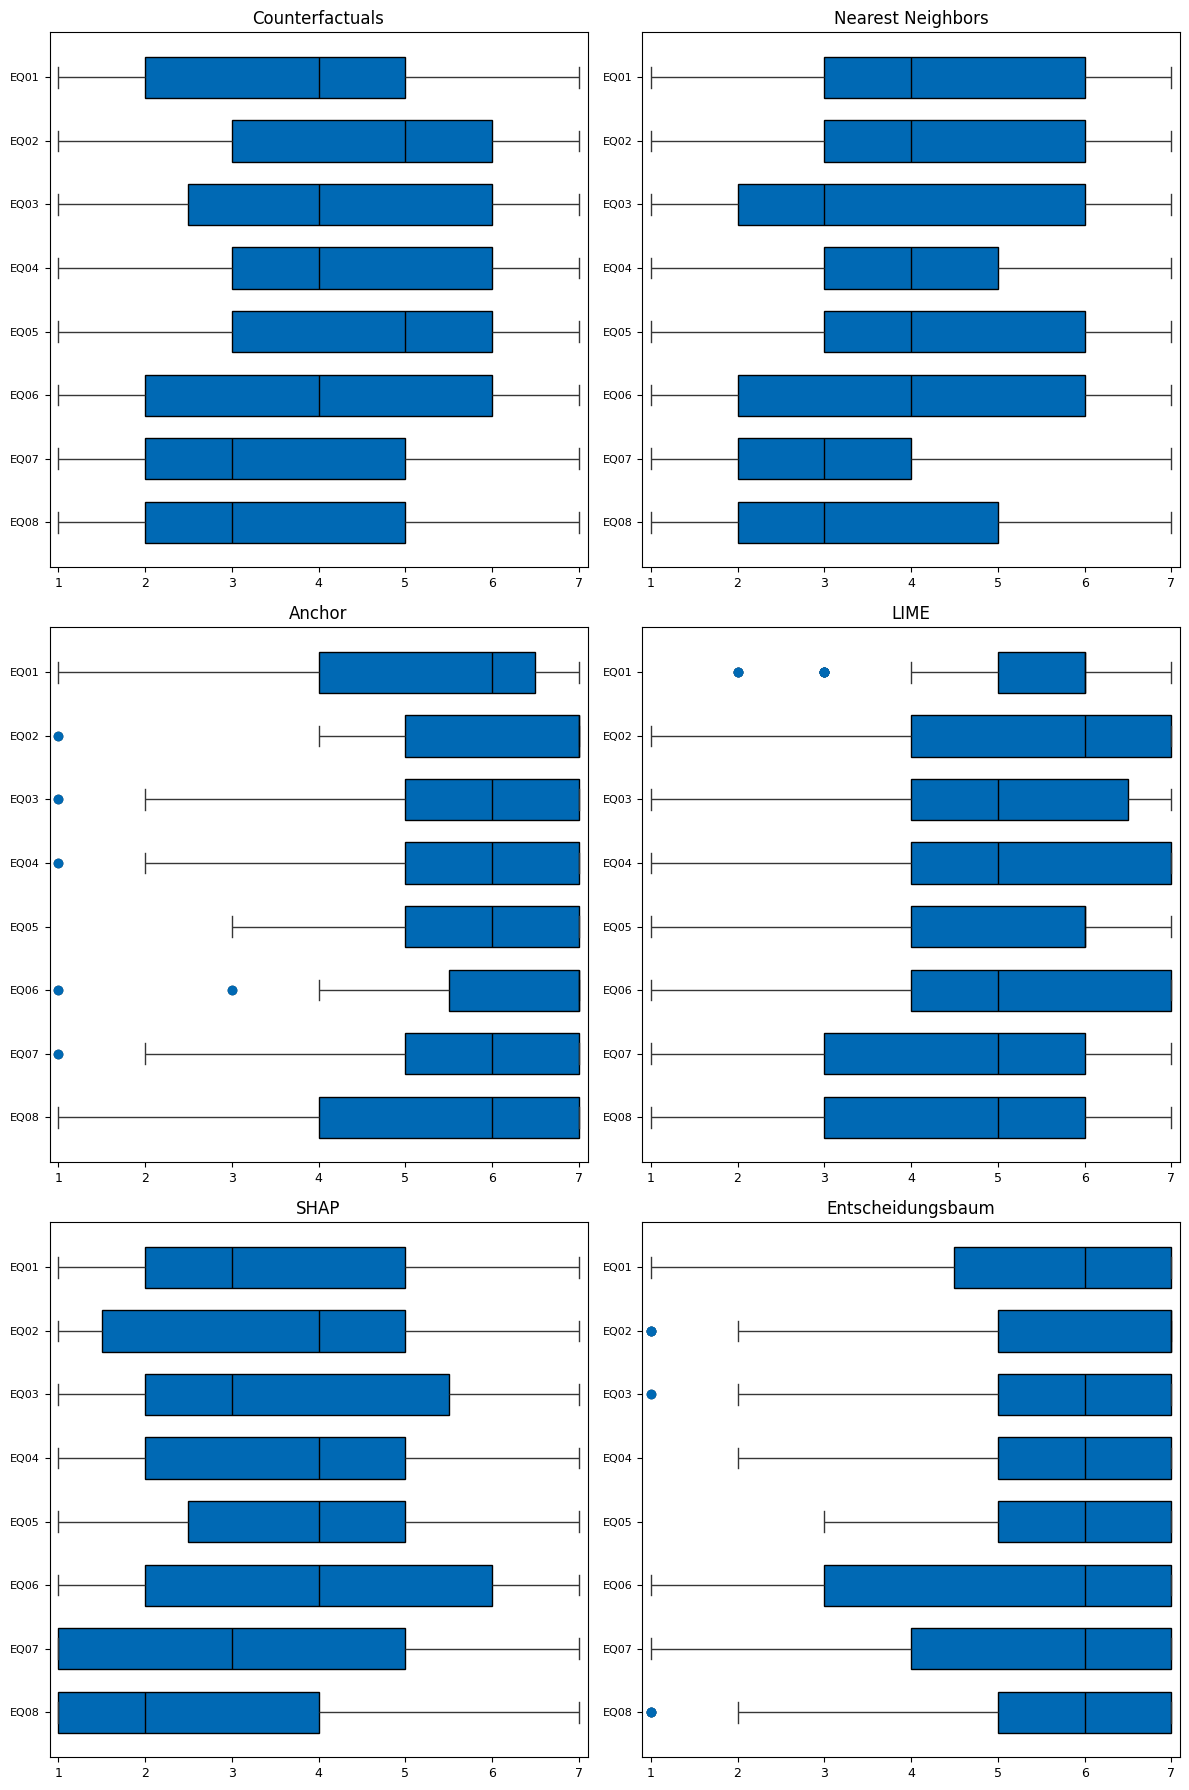

In [85]:
# Boxplots der EQ-Teilfragen je XAI-Methode in einem 2x3-Grid
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3 Zeilen, 2 Spalten
axes = axes.flatten()

for i, abbr in enumerate(List_XAI_Abbr):
    question_columns = [f"{abbr}[EQ{str(j).zfill(2)}]" for j in range(1, 9)]
    df_melted = df.melt(value_vars=question_columns, var_name='Frage', value_name='Bewertung')
    
    sns.boxplot(
        x='Bewertung', y='Frage', data=df_melted,
        width=0.65, color=plt_color, orient='h', saturation=1,
        ax=axes[i],
        boxprops=dict(edgecolor="black"),
        medianprops=dict(color="black")
    )
    
    axes[i].set_title(f'{abbr_to_fullname[abbr]}', fontsize=12)
    axes[i].set_xlim(0.9, 7.1)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].set_yticklabels(["EQ01", "EQ02", "EQ03", "EQ04", "EQ05", "EQ06", "EQ07", "EQ08"], fontsize=8) 
    # plt.yticks(ticks=range(len(List_XAI_Abbr)), labels=[abbr_to_fullname[abbr] for abbr in List_XAI_Abbr], fontsize=9)

    # Ausreißer und extreme Ausreißer markieren
    for Frage in df_melted['Frage'].unique():
        frage_data = df_melted[df_melted['Frage'] == Frage]

        Q1 = frage_data['Bewertung'].quantile(0.25)
        Q3 = frage_data['Bewertung'].quantile(0.75)
        IQR = Q3 - Q1
        outlier_lower_bound = Q1 - 1.5 * IQR
        outlier_upper_bound = Q3 + 1.5 * IQR
        extreme_lower_bound = Q1 - 3 * IQR
        extreme_upper_bound = Q3 + 3 * IQR

        outliers = frage_data[(frage_data['Bewertung'] < outlier_lower_bound) | (frage_data['Bewertung'] > outlier_upper_bound)]
        extreme_outliers = frage_data[(frage_data['Bewertung'] < extreme_lower_bound) | (frage_data['Bewertung'] > extreme_upper_bound)]
        axes[i].scatter(outliers['Bewertung'], outliers['Frage'], color=plt_color, zorder=5, label='Ausreißer')
        axes[i].scatter(extreme_outliers['Bewertung'], extreme_outliers['Frage'], color=plt_color, marker="*", zorder=6, label='Extreme Ausreißer')


# Überflüssige Subplots entfernen (falls weniger als 6 Methoden)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Gesamttitel hinzufügen
# fig.suptitle('Boxplots der EQ-Teilfragen je XAI-Methode', fontsize=14, y=0.92)

plt.tight_layout()
plt.show()

# Speichern
fig.savefig('Diagramme\Boxplot_SCS-Teilfragen_AlleMethoden.png', dpi=300)


<>:41: SyntaxWarning: invalid escape sequence '\B'
<>:41: SyntaxWarning: invalid escape sequence '\B'
C:\Users\JuliusSchmidt\AppData\Local\Temp\ipykernel_95184\3560845732.py:41: SyntaxWarning: invalid escape sequence '\B'
  fig.savefig('Diagramme\Boxplot_EQ-Gesamtwerte.png', dpi=300)


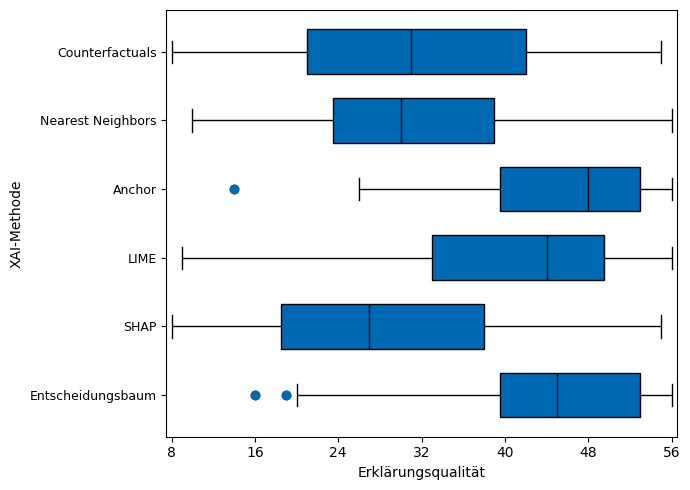

In [86]:
# Boxplots der EQ-Gesamtwerte je XAI-Methode mit seaborn und Kennzeichnung der Ausreißer
# Ausreißer, der mehr um als 1.5*IQR vom Quartil entfernt ist werden, werden mit Punkten markiert
# Ausreißer, die mehr als 3*IQR vom Quartil entfernt sind, werden mit Sternen markiert
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 5))
df_melted_sum = df.melt(value_vars=List_XAI_Sum, var_name='Methode', value_name='EQ_Summe')
sns.boxplot(x='EQ_Summe', y='Methode', data=df_melted_sum, width=0.65, color=plt_color, linecolor='black', orient='h', saturation=1)
#plt.title('Boxplot der EQ-Gesamtwerte je XAI-Methode')
plt.ylabel('XAI-Methode')
plt.xlabel('Erklärungsqualität')
plt.xlim(7.5, 56.5)
# x-skala in 7er schnritten
plt.xticks(np.arange(8, 57, 8))
# Beschriftung der y-Achse mit vollständigen Methodennamen
plt.yticks(ticks=range(len(List_XAI_Abbr)), labels=[abbr_to_fullname[abbr] for abbr in List_XAI_Abbr], fontsize=9)


# Ausreißer markieren
# Berechnung der Quartile und IQR
Q1 = df_melted_sum.groupby('Methode')['EQ_Summe'].quantile(0.25)
Q2 = df_melted_sum.groupby('Methode')['EQ_Summe'].quantile(0.5)
Q3 = df_melted_sum.groupby('Methode')['EQ_Summe'].quantile(0.75)
IQR = Q3 - Q1
# Definition der Ausreißer-Grenzen
outlier_lower_bound = Q1 - 1.5 * IQR
outlier_upper_bound = Q3 + 1.5 * IQR
extreme_lower_bound = Q1 - 3 * IQR
extreme_upper_bound = Q3 + 3 * IQR
# Ausreißer und extreme Ausreißer markieren
for method in df_melted_sum['Methode'].unique():
    method_data = df_melted_sum[df_melted_sum['Methode'] == method]
    outliers = method_data[(method_data['EQ_Summe'] < outlier_lower_bound[method]) | (method_data['EQ_Summe'] > outlier_upper_bound[method])]
    extreme_outliers = method_data[(method_data['EQ_Summe'] < extreme_lower_bound[method]) | (method_data['EQ_Summe'] > extreme_upper_bound[method])]
    plt.scatter(y=outliers['Methode'], x=outliers['EQ_Summe'], color=plt_color, zorder=5)
    plt.scatter(y=extreme_outliers['Methode'], x=extreme_outliers['EQ_Summe'], color=plt_color, marker='*', s=100, zorder=5)

plt.tight_layout()
fig = plt.gcf()
plt.show()
fig.savefig('Diagramme\Boxplot_EQ-Gesamtwerte.png', dpi=300)

# Inferenzstatistische Analyse

## Test auf Vorbedingungen der rmANOVA

<>:97: SyntaxWarning: invalid escape sequence '\Q'
<>:97: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\JuliusSchmidt\AppData\Local\Temp\ipykernel_95184\445292090.py:97: SyntaxWarning: invalid escape sequence '\Q'
  fig.savefig('Diagramme\QQ_Plots_Residuen.png', dpi=300)


Normaltest auf Basis von  D’Agostino und Pearson’s:
             Methode  Statistik  p-Wert Normalverteilung
0    Counterfactuals       4.73  0.0940               Ja
1  Nearest Neighbors       1.53  0.4660               Ja
2             Anchor       9.52  0.0086             Nein
3               LIME       3.66  0.1608               Ja
4               SHAP       3.01  0.2221               Ja
5  Entscheidungsbaum       7.18  0.0275             Nein
Shapiro-Wilk Test:
             Methode  Statistik  p-Wert Normalverteilung
0    Counterfactuals     0.9714  0.2520               Ja
1  Nearest Neighbors     0.9723  0.2738               Ja
2             Anchor     0.8958  0.0003             Nein
3               LIME     0.9367  0.0091             Nein
4               SHAP     0.9674  0.1723               Ja
5  Entscheidungsbaum     0.9036  0.0006             Nein
Kolmogorov-Smirnov Test:
             Methode  Statistik  p-Wert Normalverteilung
0    Counterfactuals     0.0782  0.8901          

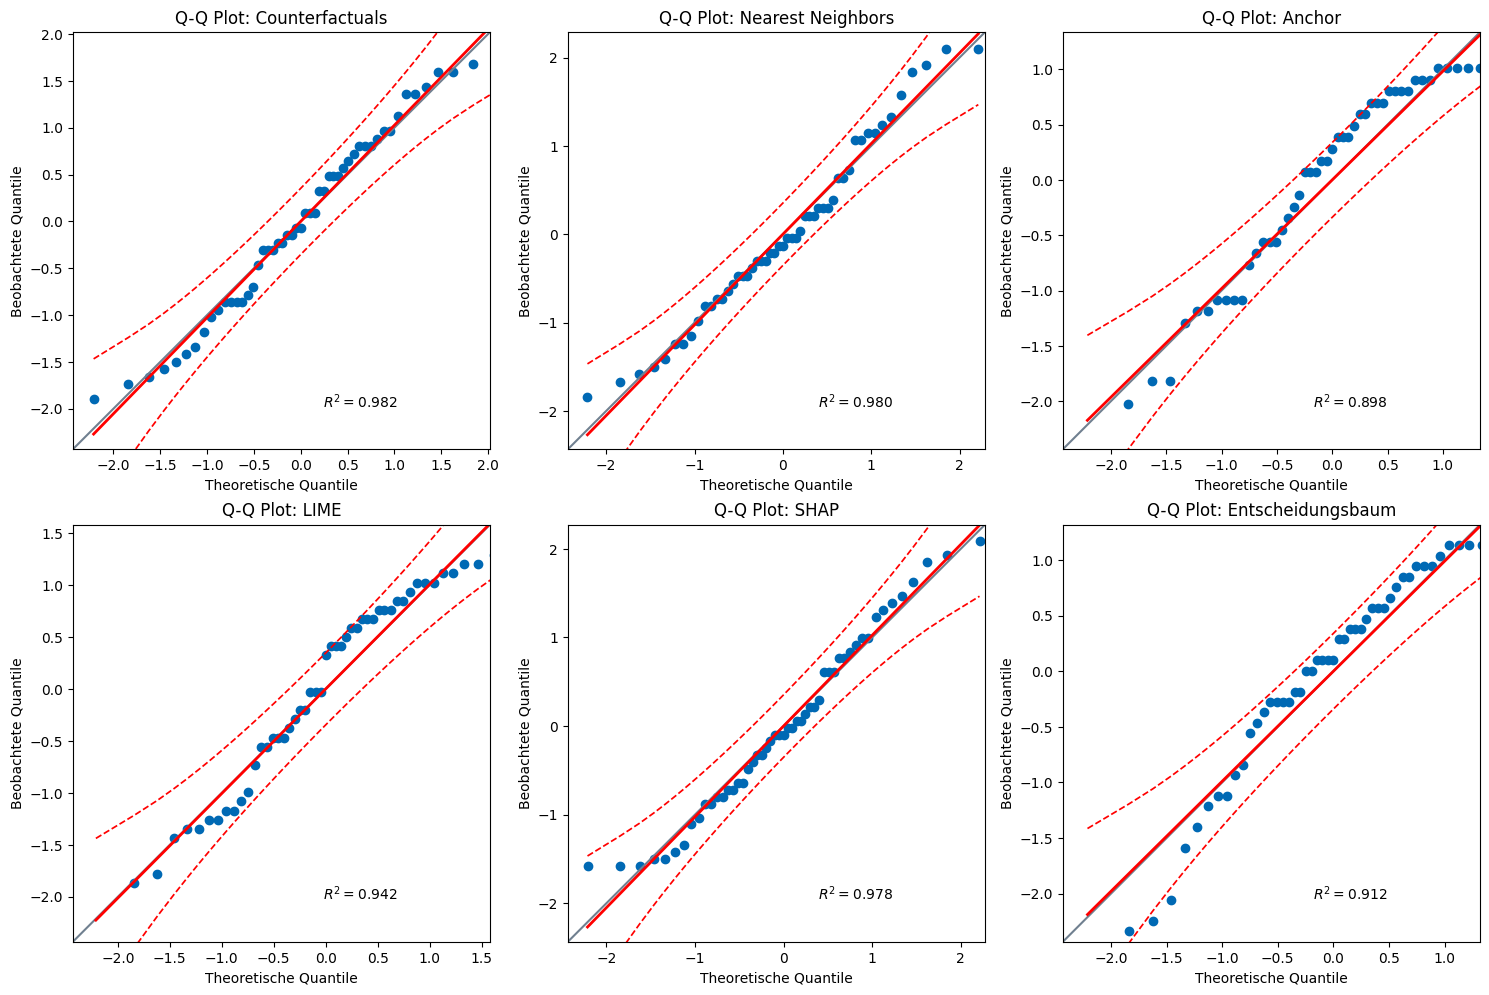

In [87]:
# Residuen in DF hinzufügen
List_XAI_Residuen = []
for item in List_XAI_Sum:
    s = pd.Series(df[item])
    resid_col = f"Residuen_{item.split('_')[1]}"
    df[resid_col] = s - s.mean()
    List_XAI_Residuen.append(resid_col)

# Residuen auf Normalverteilung testen
df_normaltest = pd.DataFrame(columns=["Methode", "Statistik", "p-Wert", "Normalverteilung"])
for item in List_XAI_Residuen:
    s = pd.Series(df[item])
    stat, p = stats.normaltest(s)
    normalverteilung = "Ja" if p > 0.05 else "Nein"
    df_normaltest.loc[len(df_normaltest)] = [abbr_to_fullname[item.split("_")[1]], round(stat, 2), round(p, 4), normalverteilung]
print("Normaltest auf Basis von  D’Agostino und Pearson’s:")
print(df_normaltest)

# Residuen auf Normalverteilung testen mit Shapiro-Wilk
df_shapiro = pd.DataFrame(columns=["Methode", "Statistik", "p-Wert", "Normalverteilung"])
for item in List_XAI_Residuen:
    s = pd.Series(df[item])
    stat, p = stats.shapiro(s)
    normalverteilung = "Ja" if p > 0.05 else "Nein"
    df_shapiro.loc[len(df_shapiro)] = [abbr_to_fullname[item.split("_")[1]], round(stat, 4), round(p, 4), normalverteilung]
print("Shapiro-Wilk Test:")
print(df_shapiro)

# Residuen auf Normalverteilung mit Kolmogorov-Smirnov testen
df_ks = pd.DataFrame(columns=["Methode", "Statistik", "p-Wert", "Normalverteilung"])
for item in List_XAI_Residuen:
    s = pd.Series(df[item])
    stat, p = stats.kstest(s, 'norm', args=(s.mean(), s.std()))
    normalverteilung = "Ja" if p > 0.05 else "Nein"
    df_ks.loc[len(df_ks)] = [abbr_to_fullname[item.split("_")[1]], round(stat, 4), round(p, 4), normalverteilung]
print("Kolmogorov-Smirnov Test:")
print(df_ks)

# df_wide für Summen der EQ-Werte
df_wide_sums = df[["Sum_CF", "Sum_NN", "Sum_Anchor", "Sum_LIME", "Sum_SHAP", "Sum_DT"]]

# Varianz-Homogenität mit Lavene-Test testen
groups = [df[m].dropna() for m in List_XAI_Sum]
levene_stat, levene_p = stats.levene(*groups)
print(f"Levene-Test: W={levene_stat:.3f}, p={levene_p:.3f}")
if levene_p < 0.05:
    print("→ Verletzung der Varianzhomogenität")
else:
    print("→ Varianzen homogen")


df_mauchly = pd.DataFrame(columns=["W", "p-Wert", "Sphärizität"])
# Für pingouin.sphericity benötigen wir die Daten im "long" Format
# Erzeuge ein DataFrame im long-Format: Spalten = Methode, Residuum, Subjekt
df_long = pd.DataFrame()
for idx, col in enumerate(List_XAI_Residuen):
    temp = pd.DataFrame({
        "Methode": col,
        "Residuum": df[col].values,
        "Subjekt": df.index
    })
    df_long = pd.concat([df_long, temp], ignore_index=True)

# Pivotieren für sphericity-Test: Zeilen=Subjekt, Spalten=Methode, Werte=Residuum
df_wide = df_long.pivot(index="Subjekt", columns="Methode", values="Residuum")



# pingouin.sphericity erwartet ein 2D-Array (subjects x conditions)
spher, W, chisq, dof, pval = pg.sphericity(df_wide_sums)
print("Sphärizität: ",spher, "W: ", round(W, 3), "X²: ", round(chisq, 3),"FG: ", dof,"p-Wert: ",  round(pval, 3))


# q-q-Plots mit Konfidenzintervalle der Residuen
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
import math
def plot_qq(residuen_liste):
    num_plots = len(residuen_liste)
    cols = 3
    rows = math.ceil(num_plots / cols)
    plt.figure(figsize=(cols * 5, rows * 5))

    for i, item in enumerate(residuen_liste):
        s = pd.Series(df[item])
        plt.subplot(rows, cols, i + 1)
        #stats.probplot(s, dist="norm", plot=plt)
        pg.qqplot(s, dist='norm', confidence=.95, color=plt_color)
        plt.title(f"Q-Q Plot: {abbr_to_fullname[item.split('_')[1]]}")
        plt.xlabel('Theoretische Quantile')
        plt.ylabel('Beobachtete Quantile')

    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    fig.savefig('Diagramme\QQ_Plots_Residuen.png', dpi=300)

plot_qq(List_XAI_Residuen)

## rmANOVA

In [88]:
# wide Format für RM ANOVA
df_anova = df[List_XAI_Sum]
df_anova

,Sum_CF,Sum_NN,Sum_Anchor,Sum_LIME,Sum_SHAP,Sum_DT
0,38,46,34,50,18,56
1,31,30,53,25,30,56
3,43,39,38,54,9,38
4,8,13,46,38,10,19
5,38,24,35,26,28,44
6,42,35,33,35,26,54
7,28,34,49,48,36,44
8,36,29,42,47,19,42
9,39,28,55,48,27,41
10,42,27,56,55,41,50


In [89]:
# one way RM ANOVA im wide Format mit pingouin
anova_results = pg.rm_anova(data=df_anova, 
                             detailed=False,
                             correction='auto',
                             effsize="np2")
anova_results

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Within,5,250,23.380852,2.934539e-19,0.318623,0.908358


In [90]:
# Statistische Power der RM ANOVA berechnen
# n = Anzahl der Probanden
# m = Anzahl der Messzeitpunkte (hier: 6) 
n, m = df_anova.shape
round(pg.power_rm_anova(eta_squared=0.2478, m=m, n=n, epsilon=0.9083),10)

1.0

In [91]:
# Korrelation zwischen den Messzeitpunkten berechnen
corr = np.diag(df_anova.corr(), k=1)
avgcorr = np.tanh(np.arctanh(corr).mean())
round(avgcorr, 4)

0.1891

In [92]:
# Power der RM ANOVA mit Korrelation zwischen den Messzeitpunkten
round(pg.power_rm_anova(eta_squared=0.2478, m=m, n=n, epsilon=0.9083, corr=avgcorr), 10)

1.0

In [93]:
print('n: %.4f' % pg.power_rm_anova(eta_squared=0.1, m=6, power=0.80))

n: 10.7610


## t-Tests

In [94]:
# t-test mit Holm-Bonferroni Korrektur für den Post-Hoc Test und paarweisen Vergleich der XAI-Methoden
from itertools import combinations
pairwise_results = pd.DataFrame(columns=["Methode 1", "Methode 2", "t-Statistik", "p-Wert", "p-Wert korrigiert", "Signifikant", "Cohen's d", "r", "power"])
alpha = 0.05
for (item1, item2) in combinations(List_XAI_Sum, 2): 
    s1 = pd.Series(df[item1])
    s2 = pd.Series(df[item2])
    t_stat, p_val = stats.ttest_rel(s1, s2)
    cohen_d = (s1.mean() - s2.mean()) / np.sqrt((s1.std() ** 2 + s2.std() ** 2) / 2)
    power_result = pg.power_ttest(d=cohen_d, n=len(s1), alpha=alpha, alternative='two-sided', contrast='paired')
    pairwise_results.loc[len(pairwise_results)] = [
        abbr_to_fullname[item1.split("_")[1]],
        abbr_to_fullname[item2.split("_")[1]],
        round(t_stat, 4),
        round(p_val, 4),
        None,  # Platzhalter für korrigierten p-Wert
        None,  # Platzhalter für Signifikanz
        round(cohen_d, 3),
        round(np.sqrt(t_stat**2 / (t_stat**2 + (n - 1))), 3),  # Korrelationskoeffizient r
        round(power_result, 4)
    ]
# Holm-Bonferroni Korrektur
reject, pvals_corrected, _, _ = multipletests(pairwise_results["p-Wert"], alpha=alpha, method='holm')
pairwise_results["p-Wert korrigiert"] = np.round(pvals_corrected, 4)
pairwise_results["Signifikant"] = np.where(reject, "Ja", "Nein")

pairwise_results

,Methode 1,Methode 2,t-Statistik,p-Wert,p-Wert korrigiert,Signifikant,Cohen's d,r,power
0,Counterfactuals,Nearest Neighbors,0.1933,0.8475,0.8944,Nein,0.029,0.027,0.0547
1,Counterfactuals,Anchor,-6.5298,0.0000,0.0000,Ja,-1.190,0.678,1.0000
2,Counterfactuals,LIME,-3.6398,0.0006,0.0042,Ja,-0.696,0.458,0.9982
3,Counterfactuals,SHAP,1.5543,0.1264,0.5640,Nein,0.286,0.215,0.5163
4,Counterfactuals,Entscheidungsbaum,-5.9233,0.0000,0.0000,Ja,-1.023,0.642,1.0000
5,Nearest Neighbors,Anchor,-7.3485,0.0000,0.0000,Ja,-1.279,0.721,NaN
6,Nearest Neighbors,LIME,-4.4067,0.0001,0.0008,Ja,-0.755,0.529,0.9996
7,Nearest Neighbors,SHAP,1.5503,0.1274,0.5640,Nein,0.267,0.214,0.4653
8,Nearest Neighbors,Entscheidungsbaum,-5.9500,0.0000,0.0000,Ja,-1.098,0.644,1.0000
9,Anchor,LIME,2.7076,0.0093,0.0558,Nein,0.471,0.358,0.9092


In [95]:
# t-test mit Holm-Bonferroni Korrektur für den Post-Hoc Test und paarweisen Vergleich der XAI-Methoden
from itertools import permutations
pairwise_results_one_sided = pd.DataFrame(columns=["Methode 1", "Methode 2", "t-Statistik", "p-Wert", "p-Wert korrigiert", "Signifikant", "Cohen's d"])
alpha = 0.05
for (item1, item2) in permutations(List_XAI_Sum, 2): 
    s1 = pd.Series(df[item1])
    s2 = pd.Series(df[item2])
    t_stat, p_val = stats.ttest_rel(s1, s2, alternative='greater')
    cohen_d = (s1.mean() - s2.mean()) / np.sqrt((s1.std() ** 2 + s2.std() ** 2) / 2)
    pairwise_results_one_sided.loc[len(pairwise_results_one_sided)] = [
        abbr_to_fullname[item1.split("_")[1]],
        abbr_to_fullname[item2.split("_")[1]],
        round(t_stat, 4),
        round(p_val, 4),
        None,  # Platzhalter für korrigierten p-Wert
        None,  # Platzhalter für Signifikanz
        round(cohen_d, 4)
    ]
# Holm-Bonferroni Korrektur
reject, pvals_corrected, _, _ = multipletests(pairwise_results_one_sided["p-Wert"], alpha=alpha, method='holm')
pairwise_results_one_sided["p-Wert korrigiert"] = np.round(pvals_corrected, 4)
pairwise_results_one_sided["Signifikant"] = np.where(reject, "Ja", "Nein")

pairwise_results_one_sided.query("Signifikant == 'Ja'")

,Methode 1,Methode 2,t-Statistik,p-Wert,p-Wert korrigiert,Signifikant,Cohen's d
10,Anchor,Counterfactuals,6.5298,0.0000,0.0000,Ja,1.1904
11,Anchor,Nearest Neighbors,7.3485,0.0000,0.0000,Ja,1.2788
13,Anchor,SHAP,7.6268,0.0000,0.0000,Ja,1.4990
15,LIME,Counterfactuals,3.6398,0.0003,0.0066,Ja,0.6964
16,LIME,Nearest Neighbors,4.4067,0.0000,0.0000,Ja,0.7547
18,LIME,SHAP,5.0958,0.0000,0.0000,Ja,0.9895
25,Entscheidungsbaum,Counterfactuals,5.9233,0.0000,0.0000,Ja,1.0230
26,Entscheidungsbaum,Nearest Neighbors,5.9500,0.0000,0.0000,Ja,1.0979
29,Entscheidungsbaum,SHAP,6.5905,0.0000,0.0000,Ja,1.3212


## Friedman-Test

In [96]:
#Friedman-Test über alle XAI-Methoden mit pingouin
friedman_results = pg.friedman(data=df_anova, method='chisq')
friedman_results

,Source,W,ddof1,Q,p-unc
Friedman,Within,0.277236,5,70.695233,7.343873e-14


## Wilcoxon-Test

In [97]:
# Wilcoxon-Test mit Holm-Bonferroni Korrektur als Post-Hoc Test für den paarweisen Vergleich der XAI-Methoden
from itertools import combinations
pairwise_wilcoxon = pd.DataFrame(columns=["Methode 1", "Methode 2", "W-Statistik", "p-Wert", "p-Wert korrigiert", "Signifikant", "r"])
alpha = 0.05
for (item1, item2) in combinations(List_XAI_Sum, 2): 
    s1 = pd.Series(df[item1])
    s2 = pd.Series(df[item2])
    w_stat, p_val = stats.wilcoxon(s1, s2)
    # Berechnung des Effektstärke r
    n = len(s1)
    z = stats.norm.ppf(p_val / 2)  # z-Wert für zweiseitigen Test
    r = abs(z) / np.sqrt(n)
    pairwise_wilcoxon.loc[len(pairwise_wilcoxon)] = [
        abbr_to_fullname[item1.split("_")[1]],
        abbr_to_fullname[item2.split("_")[1]],
        round(w_stat, 4),
        round(p_val, 4),
        None,  # Platzhalter für korrigierten p-Wert
        None,  # Platzhalter für Signifikanz
        round(r, 4)
    ]

# Holm-Bonferroni Korrektur
reject, pvals_corrected, _, _ = multipletests(pairwise_wilcoxon["p-Wert"], alpha=alpha, method='holm')
pairwise_wilcoxon["p-Wert korrigiert"] = np.round(pvals_corrected, 4)
pairwise_wilcoxon["Signifikant"] = np.where(reject, "Ja", "Nein")

pairwise_wilcoxon

,Methode 1,Methode 2,W-Statistik,p-Wert,p-Wert korrigiert,Signifikant,r
0,Counterfactuals,Nearest Neighbors,580.5,0.5820,0.9826,Nein,0.0771
1,Counterfactuals,Anchor,125.0,0.0000,0.0000,Ja,0.6929
2,Counterfactuals,LIME,327.5,0.0028,0.0196,Ja,0.4192
3,Counterfactuals,SHAP,495.5,0.1163,0.5185,Nein,0.2199
4,Counterfactuals,Entscheidungsbaum,149.0,0.0000,0.0000,Ja,0.6605
5,Nearest Neighbors,Anchor,105.0,0.0000,0.0000,Ja,0.7200
6,Nearest Neighbors,LIME,224.0,0.0003,0.0024,Ja,0.5041
7,Nearest Neighbors,SHAP,449.0,0.1037,0.5185,Nein,0.2279
8,Nearest Neighbors,Entscheidungsbaum,155.5,0.0000,0.0000,Ja,0.6518
9,Anchor,LIME,380.5,0.0130,0.0780,Nein,0.3477


In [98]:
# einseiger Wilcoxon-Test mit Holm-Bonferroni Korrektur als Post-Hoc Test für den paarweisen Vergleich der XAI-Methoden
from itertools import permutations
pairwise_wilcoxon_one_tailed = pd.DataFrame(columns=["Methode 1", "Methode 2", "W-Statistik", "p-Wert", "p-Wert korrigiert", "Signifikant", "r"])
alpha = 0.05
for (item1, item2) in permutations(List_XAI_Sum, 2): 
    s1 = pd.Series(df[item1])
    s2 = pd.Series(df[item2])
    w_stat, p_val = stats.wilcoxon(s1, s2, alternative='greater')  # einseitiger Test
    # Berechnung des Effektstärke r
    n = len(s1)
    z = stats.norm.ppf(p_val)  # z-Wert für einseitigen Test
    r = abs(z) / np.sqrt(n)
    pairwise_wilcoxon_one_tailed.loc[len(pairwise_wilcoxon_one_tailed)] = [
        abbr_to_fullname[item1.split("_")[1]],
        abbr_to_fullname[item2.split("_")[1]],
        round(w_stat, 4),
        round(p_val, 4),
        None,  # Platzhalter für korrigierten p-Wert
        None,  # Platzhalter für Signifikanz
        round(r, 4)
    ]

# Holm-Bonferroni Korrektur
reject, pvals_corrected, _, _ = multipletests(pairwise_wilcoxon_one_tailed["p-Wert"], alpha=alpha, method='holm')
pairwise_wilcoxon_one_tailed["p-Wert korrigiert"] = np.round(pvals_corrected, 4)
pairwise_wilcoxon_one_tailed["Signifikant"] = np.where(reject, "Ja", "Nein")

pairwise_wilcoxon_one_tailed.query("Signifikant == 'Ja'")

,Methode 1,Methode 2,W-Statistik,p-Wert,p-Wert korrigiert,Signifikant,r
10,Anchor,Counterfactuals,1150.0,0.0000,0.0000,Ja,0.6929
11,Anchor,Nearest Neighbors,1170.0,0.0000,0.0000,Ja,0.7200
13,Anchor,SHAP,1228.0,0.0000,0.0000,Ja,0.7418
15,LIME,Counterfactuals,947.5,0.0014,0.0308,Ja,0.4192
16,LIME,Nearest Neighbors,904.0,0.0002,0.0046,Ja,0.5041
18,LIME,SHAP,1043.0,0.0000,0.0000,Ja,0.5998
25,Entscheidungsbaum,Counterfactuals,1126.0,0.0000,0.0000,Ja,0.6605
26,Entscheidungsbaum,Nearest Neighbors,1119.5,0.0000,0.0000,Ja,0.6518
29,Entscheidungsbaum,SHAP,1149.0,0.0000,0.0000,Ja,0.6915


# Untersuchung des Rankings

In [99]:
# Friedman-Test für das Ranking der XAI-Methoden
ranking_columns = ["Darstellung C", "Darstellung N", "Darstellung A", "Darstellung L", "Darstellung S", "Darstellung D"]
df_ranking = df[ranking_columns]
friedman_ranking_results = pg.friedman(data=df_ranking, method='chisq')
friedman_ranking_results

,Source,W,ddof1,Q,p-unc
Friedman,Within,0.235986,5,60.176471,1.117558e-11


# Untersuchung der Kontrollvariablen
(Hauptuntersuchung mittels PLS-SEM)

In [100]:
# Linear Mixed Model (LMM) mit statsmodels zur Kontrolle von Kovariaten
import statsmodels.formula.api as smf

# Daten in long-Format bringen: eine Zeile = (Person, Methode, EQ-Summe)
df_long = df.melt(id_vars=["id", "Alter", "Abschluss", "Vorwissen_tech", "Vorwissen_fach"],
                       value_vars=["Sum_CF", "Sum_NN", "Sum_Anchor", "Sum_LIME", "Sum_SHAP", "Sum_DT"],
                       var_name="Methode", value_name="EQ_Summe")

# LMM: EQ_Summe hängt von Methode + Kontrollvariablen ab, Person als Random Intercept
model = smf.mixedlm("EQ_Summe ~ Methode + Alter + C(Abschluss) + Vorwissen_tech + Vorwissen_fach",
                    df_long, groups=df_long["id"])
result = model.fit()
print(result.summary())


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    EQ_Summe  
No. Observations:    306        Method:                REML      
No. Groups:          51         Scale:                 114.2637  
Min. group size:     6          Log-Likelihood:        -1153.5716
Max. group size:     6          Converged:             Yes       
Mean group size:     6.0                                         
-----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept            42.340    3.068 13.801 0.000  36.327  48.353
Methode[T.Sum_CF]   -13.451    2.117 -6.354 0.000 -17.600  -9.302
Methode[T.Sum_DT]    -1.392    2.117 -0.658 0.511  -5.541   2.757
Methode[T.Sum_LIME]  -5.000    2.117 -2.362 0.018  -9.149  -0.851
Methode[T.Sum_NN]   -13.804    2.117 -6.521 0.000 -17.953  -9.655
Methode[T.Sum_SHAP] -17.